In [104]:
import json

scientific_articles = []
with open('json/science.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        scientific_articles.append(article[1])

conspiracy_articles = [] 
with open('json/conspiracy.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        conspiracy_articles.append(article[1])

min_len = min(len(scientific_articles), len(conspiracy_articles))
scientific_articles = scientific_articles[:min_len]
conspiracy_articles = conspiracy_articles[:min_len]

print(min_len)

257


In [27]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from dateutil.parser import parse
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

import string
import nltk

class BagOfWords:
    def __init__(self, tokenized_paragraph: list, is_positive: bool):
        self.sentences = tokenized_paragraph
        self.is_positive = is_positive

    def tokenize(self):
        self.words = []
        for sentence in self.sentences:
            for word in word_tokenize(sentence):
                self.words.append(word)

    def to_lower_case(self):
        for i in range(len(self.words)):
            self.words[i] = self.words[i].lower()

    def clean_data(self):
        noise = ['...', "n't"]
        def is_time_or_date(word):  
            try:
                parsed = parse(word)
                return True
            except:
                return False

        def is_link(word):
            suffixes = ['.com', '.org', '.edu', '.gov', '.int', '.co', '.net', '.au', '.us', '.uk', '.ne', 'news']
            for suffix in suffixes:
                if suffix in word:
                    return True
            return False

        for i in range(len(self.words)-1, -1, -1):
            if len(self.words[i]) <= 2 or self.words[i].isnumeric() or is_time_or_date(self.words[i]) or self.words[i] in noise or is_link(self.words[i]):
                self.words.pop(i)
                continue
        
            # shave punctation off of beginnings and from the end
            start_ind, end_ind = -1, -1
            for j in range(len(self.words[i])):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    start_ind = j
                    break
            for j in range(len(self.words[i])-1, -1, -1):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    end_ind = j
                    break

            if (start_ind == 0 and end_ind == len(self.words[i])-1) or start_ind >= end_ind:
                continue

            self.words[i] = self.words[i][start_ind:end_ind+1]

    def remove_stop_words(self):
        for i in range(len(self.words)-1, -1, -1):
            if self.words[i] in stopwords.words('english'):
                self.words.pop(i)  

    def normalize_words(self):
        def get_part_of_speech(provided_word):
            _, part_of_speech = nltk.pos_tag([provided_word])[0]
            if 'NN' in part_of_speech:
                return 'n'
            if 'VB' in part_of_speech:
                return 'v'
            if 'JJ' in part_of_speech:
                return 'a'
            if 'RB' in part_of_speech:
                return 'r'
            return 'n'

        lemmatizer = WordNetLemmatizer()
        for i in range(len(self.words)):
            self.words[i] = lemmatizer.lemmatize(self.words[i], get_part_of_speech(self.words[i]))

    def create_frequency_chart(self):
        self.freqChart = dict()

        for word in self.words:
            if word not in self.freqChart:
                self.freqChart[word] = 1
            else:
                self.freqChart[word] += 1

        # sorting in ascending order by value
        self.freqChart = {word: self.freqChart[word] for word in sorted(self.freqChart, key=self.freqChart.get, reverse=True)}

    def plot_frequency_chart(self):
        words = list(self.freqChart.keys())[:100]
        frequencies = list(self.freqChart.values())[:100]

        plt.figure(figsize=(20, 5))
        plt.margins(x=0, tight=True)
        plt.bar(words, frequencies, color ='green')

        # setting title and labels
        plt.xlabel("Distinct Words")
        plt.tick_params(axis='x', which='major', labelsize=9)
        plt.xticks(rotation = 90)

        plt.ylabel(f"Frequency of Words in {self.is_positive}")
        plt.title("Frequency Chart")

        # loading the plot
        plt.show()

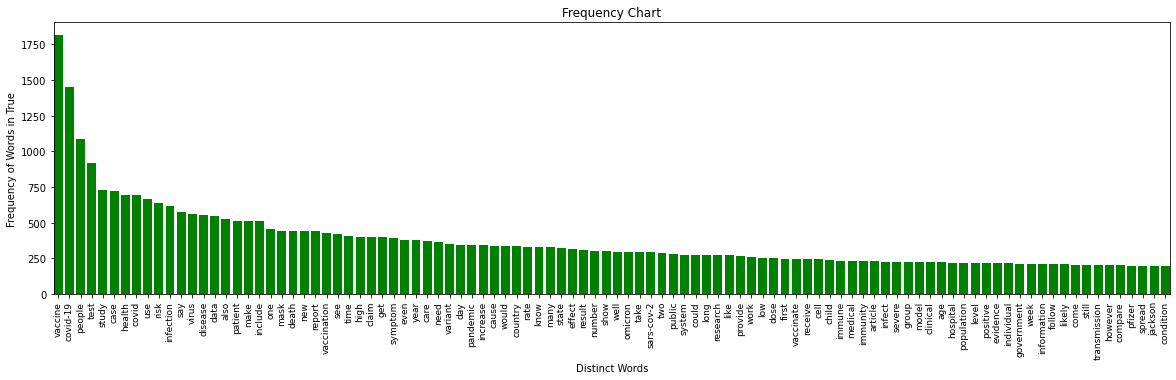

In [28]:
a = BagOfWords(scientific_articles, True)

a.tokenize()
a.to_lower_case()
a.clean_data()
a.remove_stop_words()
a.normalize_words() # todo: improve part of speech performance
a.create_frequency_chart()
a.plot_frequency_chart()

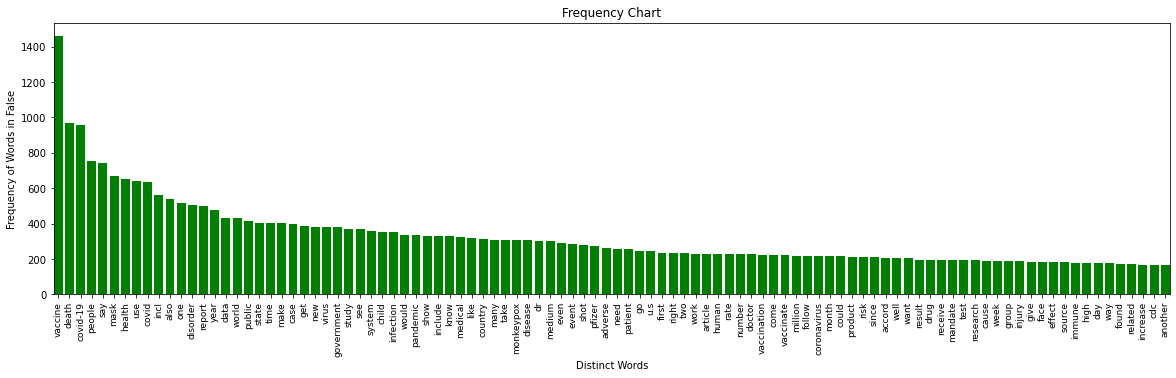

In [29]:
b = BagOfWords(conspiracy_articles, False)

# assuming rn that everything is clean because of testing on 'a', will test later
b.tokenize()
b.to_lower_case()
b.clean_data()
b.remove_stop_words()
b.normalize_words() # todo: improve part of speech performance
b.create_frequency_chart()
b.plot_frequency_chart()

In [30]:
# determine common words between the two sets of words
common_words = dict()
for word, count in a.freqChart.items():
    if word in b.freqChart:
        diff_count = count - b.freqChart[word]
        common_words[word] = diff_count/(count + b.freqChart[word])

# remove all with count 0 
# common_words = dict(filter(lambda elem: elem[1] != 0, common_words.items()))

# sorting the dictionary in descending order
common_words = {word: common_words[word] for word in sorted(common_words, key=common_words.get, reverse=True)}

In [31]:
common_words

{'jackson': 0.9898477157360406,
 'ba.2': 0.96,
 'ba.5': 0.9555555555555556,
 'at-home': 0.9555555555555556,
 'adhd': 0.9534883720930233,
 'zero-covid': 0.9375,
 'pot': 0.9325842696629213,
 'eligibility': 0.9310344827586207,
 'm': 0.9280575539568345,
 'meteor': 0.9259259259259259,
 'probability': 0.9230769230769231,
 'adjust': 0.9166666666666666,
 'mixed': 0.9166666666666666,
 'jet': 0.9166666666666666,
 'pericarditis': 0.9148936170212766,
 'brook': 0.9130434782608695,
 'creative': 0.9130434782608695,
 'interval': 0.9104477611940298,
 'payment': 0.9090909090909091,
 'loop': 0.9090909090909091,
 'screen': 0.90625,
 'ba.4': 0.9047619047619048,
 'mood': 0.9047619047619048,
 'pediatrics': 0.9047619047619048,
 'propensity': 0.9047619047619048,
 'swab': 0.9,
 'missile': 0.9,
 'cardiovascular': 0.9,
 'comorbidities': 0.8947368421052632,
 'ama': 0.8947368421052632,
 'copper': 0.8888888888888888,
 'fallacy': 0.8888888888888888,
 'datasets': 0.8888888888888888,
 'dominant': 0.8888888888888888,
 '

In [105]:
print(len(common_words))
print(sum(y > 0 for _, y in common_words.items()))
print(sum(y < 0 for _, y in common_words.items()))

5716
2554
2399


In [106]:
# plot a graph containing words on either side
x_axis, y_axis = [], []
for word, value in common_words.items():
    x_axis.append(word)
    y_axis.append(value)

In [109]:
# plt.figure(figsize=(25, 5), dpi=500)
# plt.margins(x=0, tight=True)
# plt.xlabel("Distinct Words")
# plt.ylabel("Adjusted Frequency")
# plt.title("Most-Frequent Words")
# plt.bar(x_axis, y_axis)
# plt.tick_params(axis='x', which='major', labelsize=7)
# plt.xticks(rotation = 90)
# plt.show()

In [110]:
# extract 20 most common words
sorted_words = []
for key, value in common_words.items():
    sorted_words.append([abs(value), key])
sorted_words.sort(reverse=True)

# take 20 with highest magnitudes  
relevant_words = sorted_words[:40]

# give the sign back
for word in relevant_words:
    word[0] = common_words[word[1]]

relevant_words.sort()

In [111]:
relevant_words

[[-0.98, 'interview'],
 [-0.9775280898876404, 'jab'],
 [-0.9710144927536232, 'god'],
 [-0.9661016949152542, 'intelligence'],
 [-0.9512195121951219, 'mainstream'],
 [-0.9459459459459459, 'birth'],
 [-0.9452054794520548, 'pharma'],
 [-0.9428571428571428, 'establishment'],
 [-0.9411764705882353, 'arrest'],
 [-0.9340659340659341, 'inject'],
 [-0.9333333333333333, 'farmer'],
 [-0.9333333333333333, 'georgia'],
 [-0.9310344827586207, 'dollar'],
 [-0.9259259259259259, 'brian'],
 [-0.9259259259259259, 'wilson'],
 [-0.9230769230769231, 'infestation'],
 [-0.9230769230769231, 'lymphatic'],
 [-0.9230769230769231, 'musculoskeletal'],
 [-0.9230769230769231, 'neoplasm'],
 [-0.9230769230769231, 'subcutaneous'],
 [-0.9230769230769231, 'thoracic'],
 [-0.92, 'adam'],
 [-0.92, 'reset'],
 [-0.9148936170212766, 'herpes'],
 [-0.9130434782608695, 'election'],
 [0.9148936170212766, 'pericarditis'],
 [0.9166666666666666, 'adjust'],
 [0.9166666666666666, 'jet'],
 [0.9166666666666666, 'mixed'],
 [0.923076923076923

plan for next week:
- split up data into testing, training set
    - in an 80-20 split
    - do this individually for scientific articles and conspiracy articles, then merge the two sets together
- after this, evaluation of well the system works with a ML model will be good
    - train model and redo-word frequency part once for the testing set and once for the training set (to prevent data leakage)
    - generate table for training and testing data (2 tables)
        - columns: for each of the 20 keywords
        - rows: count for each keyword in an article  
        - add a final column to the right displaying whether the article was a conspiracy or scientific (0 = conspiracy, 1 = scientific) 
    - train model with various different methods and evaluate test set  

In [127]:
# build the dataframe
import pandas as pd
import numpy as np

cols = {}
for word in relevant_words:
    cols[word[1]] = []

# adding scientific rows
for article in scientific_articles:
    for word in cols:
        cols[word].append(article.lower().count(word))

# adding conspiracy row
for article in conspiracy_articles:
    for word in cols:
        cols[word].append(article.lower().count(word))

data_set = pd.DataFrame(data = cols)

row_count = data_set.shape[0]/2

# setting scientific articles to 1
data_set.loc[:row_count,'article_type'] = 1

# setting conspiracy articles to 0
data_set.loc[row_count:, 'article_type'] = 0

In [128]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# data_set[data_set.columns] = scaler.fit_transform(data_set[data_set.columns])

In [129]:
data_set

,interview,jab,god,intelligence,mainstream,birth,pharma,establishment,arrest,inject,...,m,eligibility,pot,zero-covid,adhd,at-home,ba.5,ba.2,jackson,article_type
0,0,0,1,0,0,0,2,0,0,0,...,1170,0,3,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,4,0,0,0,...,382,0,0,0,0,9,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,62,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,74,0,1,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,28,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0,0,0,0,0,0,0,0,0,0,...,93,0,0,0,0,0,0,0,0,0.0
510,3,0,0,0,0,0,0,0,0,0,...,84,0,0,0,0,0,0,0,0,0.0
511,0,3,0,0,0,0,0,0,0,5,...,78,0,0,0,0,0,0,0,0,0.0
512,1,0,0,0,0,0,0,0,0,0,...,99,0,2,0,0,0,0,0,0,0.0


In [130]:
X = data_set.iloc[:, :-1]
y = data_set.iloc[:, -1]

In [131]:
X

,interview,jab,god,intelligence,mainstream,birth,pharma,establishment,arrest,inject,...,meteor,m,eligibility,pot,zero-covid,adhd,at-home,ba.5,ba.2,jackson
0,0,0,1,0,0,0,2,0,0,0,...,0,1170,0,3,0,0,0,0,0,0
1,0,0,0,0,0,0,4,0,0,0,...,0,382,0,0,0,0,9,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,62,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,74,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,28,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0,0,0,0,0,0,0,0,0,0,...,0,93,0,0,0,0,0,0,0,0
510,3,0,0,0,0,0,0,0,0,0,...,0,84,0,0,0,0,0,0,0,0
511,0,3,0,0,0,0,0,0,0,5,...,0,78,0,0,0,0,0,0,0,0
512,1,0,0,0,0,0,0,0,0,0,...,0,99,0,2,0,0,0,0,0,0


In [132]:
y

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
509    0.0
510    0.0
511    0.0
512    0.0
513    0.0
Name: article_type, Length: 514, dtype: float64

In [133]:
# split the dataframe accordingly
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = data_set['article_type'], random_state = 1)

In [134]:
def get_frequency(data_set):
    return (data_set != 1).values.sum()/len(data_set) * 100

In [135]:
get_frequency(y_train)

50.121654501216554

In [121]:
get_frequency(y_test)

49.51456310679612

In [136]:
# implement bag of words again -> black box the rest of the code so that only new models need to be added below

In [137]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)
predictions = model.predict(X_test)

/Users/isobarbaric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [138]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(y_test, predictions))
print(f1_score(y_test, predictions))

0.7572815533980582
0.7933884297520661


In [139]:
predictions

array([0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0.])

In [140]:
y_test

318    0.0
479    0.0
256    1.0
466    0.0
457    0.0
      ... 
372    0.0
182    1.0
190    1.0
16     1.0
432    0.0
Name: article_type, Length: 103, dtype: float64